In [1]:
import os
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam

In [2]:
# Function to load and preprocess dataset
def load_dataset(dataset_path, target_size=(224, 224)):
    data = []
    labels = []
    class_names = []
    # Loop through class folders
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            class_names.append(class_name)
            class_index = len(class_names) - 1
            # Loop through images in class folder
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                try:
                    image = Image.open(image_path).convert('RGB')  # Ensure RGB
                    image = image.resize(target_size)  # Resize to target size
                    image_array = np.array(image)
                    data.append(image_array)
                    labels.append(class_index)
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")
    
    return np.array(data), np.array(labels), class_names

# Path to dataset
dataset_path = "/kaggle/input/leaf-images/300_dataset"

In [3]:
# Load and preprocess dataset
data, labels, class_names = load_dataset(dataset_path)

Error loading image /kaggle/input/leaf-images/300_dataset/Vad/301.jpg: cannot identify image file '/kaggle/input/leaf-images/300_dataset/Vad/301.jpg'
Error loading image /kaggle/input/leaf-images/300_dataset/Sonmohar/301.jpg: cannot identify image file '/kaggle/input/leaf-images/300_dataset/Sonmohar/301.jpg'
Error loading image /kaggle/input/leaf-images/300_dataset/Vilayati Chinch/301.jpg: cannot identify image file '/kaggle/input/leaf-images/300_dataset/Vilayati Chinch/301.jpg'


In [4]:
data = preprocess_input(data)  
labels = to_categorical(labels, num_classes=len(class_names))  # One-hot encode labels

In [5]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def conv_block(x, filters, strides=1):
    """A convolutional block with BatchNorm and ReLU activation."""
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def bottleneck_block(x, filters, strides=1, downsample=False):
    """A bottleneck residual block."""
    shortcut = x  # Save the input tensor for the skip connection

    # First 1x1 Conv layer
    x = Conv2D(filters, kernel_size=1, strides=strides, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second 3x3 Conv layer
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third 1x1 Conv layer
    x = Conv2D(filters * 4, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Downsample shortcut if required
    if downsample:
        shortcut = Conv2D(filters * 4, kernel_size=1, strides=strides, padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add skip connection
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet50(input_shape=(224, 224, 3), num_classes=10):
    """Build the ResNet-50 architecture."""
    inputs = Input(shape=input_shape)

    # Initial convolution and max-pooling
    x = Conv2D(64, kernel_size=7, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Stage 1
    x = bottleneck_block(x, 64, downsample=True)
    for _ in range(2):
        x = bottleneck_block(x, 64)

    # Stage 2
    x = bottleneck_block(x, 128, strides=2, downsample=True)
    for _ in range(3):
        x = bottleneck_block(x, 128)

    # Stage 3
    x = bottleneck_block(x, 256, strides=2, downsample=True)
    for _ in range(5):
        x = bottleneck_block(x, 256)

    # Stage 4
    x = bottleneck_block(x, 512, strides=2, downsample=True)
    for _ in range(2):
        x = bottleneck_block(x, 512)

    # Global Average Pooling and Dense layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Build the model
input_shape = (224, 224, 3)  # ImageNet size
num_classes = len(class_names)  # Use your dataset's number of classes
model = build_resnet50(input_shape=input_shape, num_classes=num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks = [early_stopping])


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.7557 - loss: 0.7157 - val_accuracy: 0.5833 - val_loss: 2.1389
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.7593 - loss: 0.7126 - val_accuracy: 0.6533 - val_loss: 3.4325
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - accuracy: 0.7751 - loss: 0.6630 - val_accuracy: 0.5667 - val_loss: 2.2648
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.8044 - loss: 0.6121 - val_accuracy: 0.6283 - val_loss: 1.5062
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.8289 - loss: 0.5249 - val_accuracy: 0.4733 - val_loss: 2.6846
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.8167 - loss: 0.5072 - val_accuracy: 0.6867 - val_loss: 0.9799
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.8387 - loss: 0.4634 - val_accuracy: 0.7183 - val_loss: 0.8639
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.8659 - loss: 0.4127 - val_accu

In [30]:
model.save('resnet_model.keras')

In [31]:
plot_model(
    xception_model,
    to_file='models/xception/Xception_architecture.png',
    show_shapes=True,
    show_layer_names=True
)

NameError: name 'plot_model' is not defined

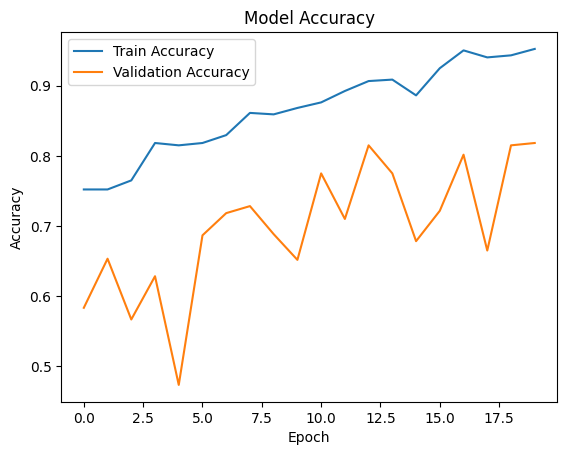

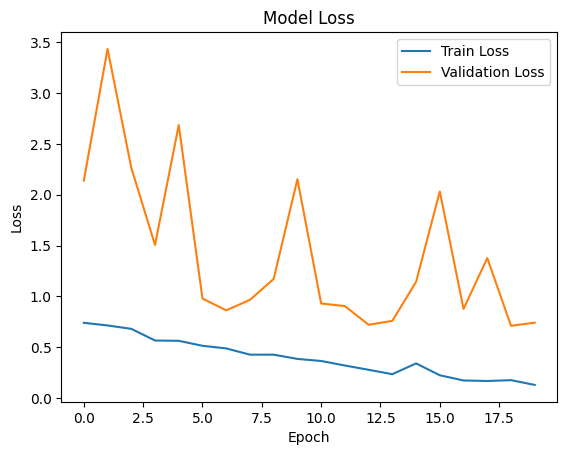

In [32]:
# You can also visualize the training history (optional)
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [33]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8293 - loss: 0.6617
Test Accuracy: 81.83%


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [35]:
# Predict on the test set
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Predicted classes
y_true_classes = np.argmax(y_test, axis=1)  # True labels


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step


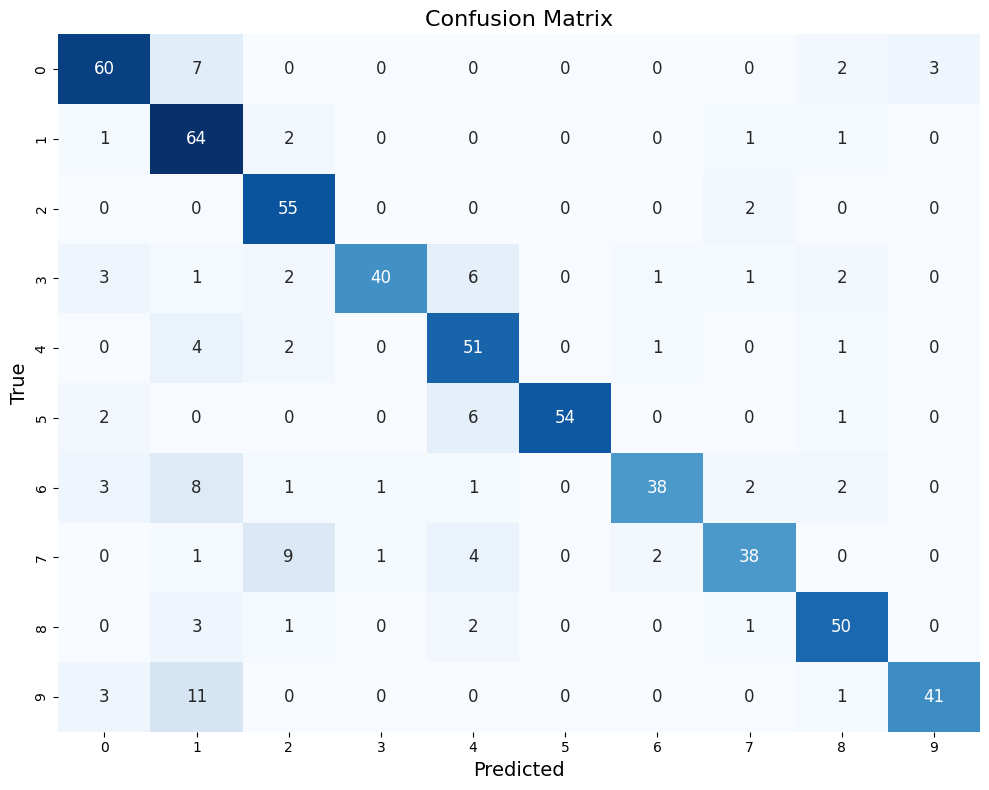

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming your y_true_classes and y_pred_classes are already defined
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Manually define the class labels or infer them from your data
class_labels = np.unique(y_true_classes)  # or define manually like ['class1', 'class2', ...]

# Create a heatmap using seaborn with a blue color palette
plt.figure(figsize=(10, 8))  # Increase the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, 
            yticklabels=class_labels, cbar=False, annot_kws={"size": 12})  # Adjust font size

# Add labels and title
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Adjust layout to ensure everything fits
plt.tight_layout()

plt.show()


Classification Report:
                     precision    recall  f1-score   support

               Vad       0.83      0.83      0.83        72
Indian Rubber Tree       0.65      0.93      0.76        69
          Sonmohar       0.76      0.96      0.85        57
   Vilayati Chinch       0.95      0.71      0.82        56
           Nilgiri       0.73      0.86      0.79        59
        Sita Ashok       1.00      0.86      0.92        63
              Apta       0.90      0.68      0.78        56
            Kashid       0.84      0.69      0.76        55
            Karanj       0.83      0.88      0.85        57
            Pimpal       0.93      0.73      0.82        56

          accuracy                           0.82       600
         macro avg       0.84      0.81      0.82       600
      weighted avg       0.84      0.82      0.82       600



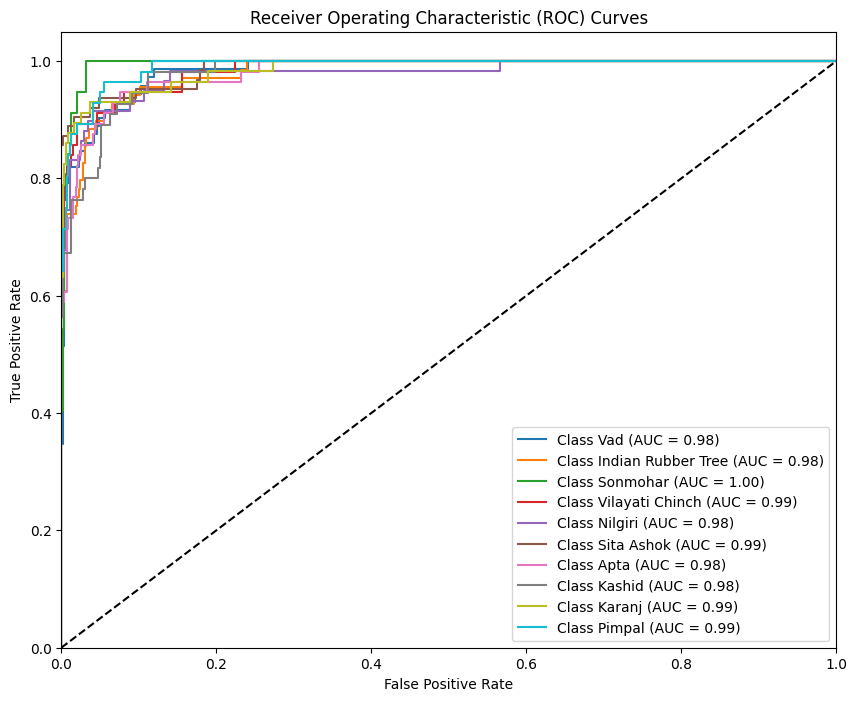

Macro-Average AUC: 0.98


In [37]:
# Precision, Recall, F1-score
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)
# ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

# Macro-Average ROC and AUC
fpr_macro, tpr_macro, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc_macro = auc(fpr_macro, tpr_macro)

print(f"Macro-Average AUC: {roc_auc_macro:.2f}")


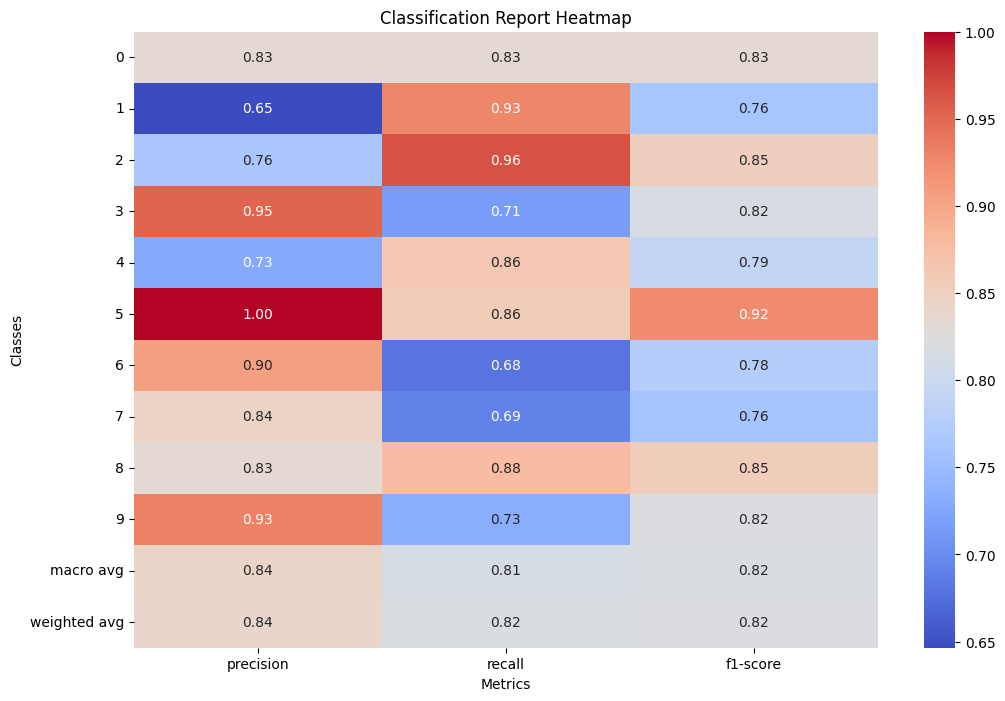

In [38]:
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(y_true_classes, y_pred_classes)

report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)

report_df = pd.DataFrame(report_dict).transpose()

if "accuracy" in report_df.index:
    report_df = report_df.drop(index="accuracy")

plt.figure(figsize=(12, 8))
sns.heatmap(report_df.iloc[:, :-1], annot=True, cmap='coolwarm', fmt=".2f")  # Exclude 'support' column
plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()